RollingBall:玩家（或智能体）通过施加力控制小球，从网格起点（[0.2*宽, 0.2*高]）移动到目标点（[0.8*宽, 0.8*高]）。

核心特点：
- **环境**：10x10 网格（可调），小球受力、摩擦（系数 0.0046）、边界碰撞（恢复系数 0.8）影响，速度上限 5.0。
- **动作**：连续力（[-0.1, 0.1]），可离散化为 5x5 动作（[-0.8, -0.4, 0, 0.4, 0.8]）并展平为 25 个动作。
- **奖励**：每步 -2.0，撞墙 -10.0，到达目标 +300.0。
- **渲染**：Pygame 显示蓝色小球、紫色目标，可选灰色轨迹，300x300 像素窗口。

In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from gym.utils.env_checker import check_env
from RL_DQN_Class import DQN,ReplayBuffer
from gym.wrappers import TimeLimit
from two_dimensional_rolling_motion import RollingBall, DiscreteActionWrapper, FlattenActionSpaceWrapper

d:\py\Anaconda3\envs\DL_pytorch_gpu\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 19: 100%|██████████| 50/50 [00:08<00:00,  6.20it/s, episode=1950, return=189.400]


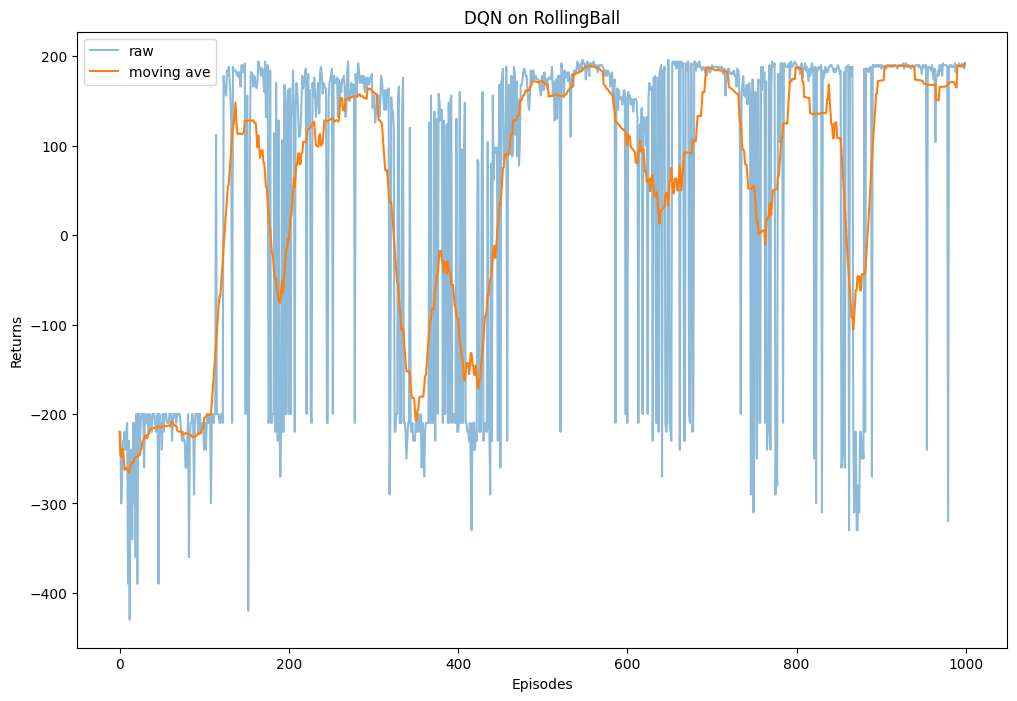

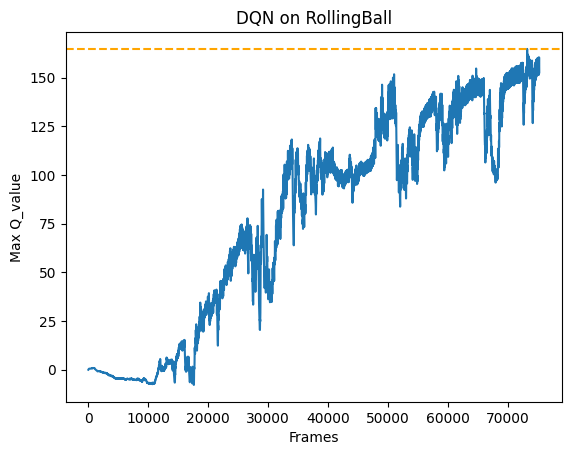

: 

In [ ]:
if __name__ == "__main__":
    def moving_average(a, window_size):
        ''' 生成序列 a 的滑动平均序列 '''
        cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
        middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
        r = np.arange(1, window_size-1, 2)
        begin = np.cumsum(a[:window_size-1])[::2] / r
        end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
        return np.concatenate((begin, middle, end))

    def set_seed(env, seed=42):
        ''' 设置随机种子 '''
        env.action_space.seed(seed)
        env.reset(seed=seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    state_dim = 4                               # 环境观测维度
    action_dim = 1                              # 环境动作维度
    action_bins = 10                            # 动作离散 bins 数量
    action_range = action_bins * action_bins    # 环境动作空间大小
    hidden_dim = 32
    lr = 1e-3
    num_episodes = 1000
    gamma = 0.99
    epsilon_start = 0.01
    epsilon_end = 0.001
    target_update = 1000
    buffer_size = 10000
    minimal_size = 5000
    batch_size = 128
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # build environment
    env = RollingBall(width=5, height=5, show_epi=True)    
    env = FlattenActionSpaceWrapper(DiscreteActionWrapper(env, bins=10))
    env = TimeLimit(env, 100)
    check_env(env.unwrapped)            # 检查环境是否符合 gym 规范
    set_seed(env, seed=42)              

    # build agent
    replay_buffer = ReplayBuffer(buffer_size)
    agent = DQN(state_dim, hidden_dim, action_dim, action_range, lr, gamma, epsilon_start, target_update, device)

    # 随机动作来填充 replay buffer
    state, _ = env.reset()
    while replay_buffer.size() <= minimal_size:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done=terminated or truncated)
        state = next_state
        if terminated or truncated:
            env.render()
            state, _ = env.reset()
        #print(replay_buffer.size())

    # 开始训练
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(20):
        with tqdm(total=int(num_episodes / 20), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 20)):
                episode_return = 0
                state, _ = env.reset()
                while True:
                    # 保存经过状态的最大Q值
                    max_q_value = agent.max_q_value_of_given_state(state) * 0.005 + max_q_value * 0.995 # 平滑处理
                    max_q_value_list.append(max_q_value)                                    
                    
                    # 选择动作移动一步
                    action = agent.take_action(state)
                    next_state, reward, terminated, truncated, _ = env.step(action)
                    
                    # 更新replay_buffer
                    replay_buffer.add(state, action, reward, next_state, done=terminated or truncated)
                    
                    # 当buffer数据的数量超过一定值后,才进行Q网络训练
                    assert replay_buffer.size() > minimal_size
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)

                    state = next_state
                    episode_return += reward

                    if terminated or truncated:
                        env.render()
                        break
                    
                    #env.render()

                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
                
        #env.render()
        agent.epsilon += (epsilon_end - epsilon_start) / 10

    # show policy performence
    mv_return_list = moving_average(return_list, 29)
    episodes_list = list(range(len(return_list)))
    plt.figure(figsize=(12,8))
    plt.plot(episodes_list, return_list, label='raw', alpha=0.5)
    plt.plot(episodes_list, mv_return_list, label='moving ave')
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.title(f'{agent._get_name()} on RollingBall')
    plt.legend()
    plt.savefig(f'./result/{agent._get_name()}.png')
    plt.show()

    # show Max Q value during training
    frames_list = list(range(len(max_q_value_list)))
    plt.plot(frames_list, max_q_value_list)
    plt.axhline(max(max_q_value_list), c='orange', ls='--')
    plt.xlabel('Frames')
    plt.ylabel('Max Q_value')
    plt.title(f'{agent._get_name()} on RollingBall')
    plt.savefig(f'./result/{agent._get_name()}_MaxQ.png')
    plt.show()
